In [2]:
import pandas as pd
import numpy as np
import joblib
import logging
import matplotlib.pyplot as plt
from datetime import time
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
    auc,
    f1_score,
    roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def preprocessing_data(data):
    # 1) имя
    data['name'] = data['first'] + ' ' + data['last']

    # 2) дроп ненужных
    data = data.drop(
        ['Unnamed: 0', 'trans_num', 'first', 'last', 'unix_time'],
        axis=1, errors='ignore'
    )

    # 3) datetime
    data['trans_date_trans_time'] = pd.to_datetime(
        data['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S'
    )
    data['trans_year']  = data['trans_date_trans_time'].dt.year
    data['trans_month'] = data['trans_date_trans_time'].dt.month
    data['trans_day']   = data['trans_date_trans_time'].dt.day
    data['trans_time']  = data['trans_date_trans_time'].dt.time
    data = data.drop('trans_date_trans_time', axis=1)

    # 4) заполнение NA
    data.fillna(-1, inplace=True)

    # 5) возраст
    data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
    current_year = pd.Timestamp.now().year
    data['age'] = current_year - data['dob'].dt.year

    # 6) время суток
    data['morning'] = np.where(
        (time(6,0) <= data['trans_time']) & (data['trans_time'] <= time(12,0)),
        1, 0
    )
    data['midday'] = np.where(
        (time(12,0) < data['trans_time']) & (data['trans_time'] <= time(18,0)),
        1, 0
    )
    data['evening'] = np.where(
        (time(18,0) < data['trans_time']) & (data['trans_time'] <= time(23,59)),
        1, 0
    )
    data['night'] = np.where(
        (time(0,0) <= data['trans_time']) & (data['trans_time'] < time(6,0)),
        1, 0
    )
    data['hour'] = data['trans_time'].apply(lambda x: x.hour)

    # 7) подсчёт повторов
    name_counts = data['name'].value_counts()
    data['name_count'] = data['name'].map(name_counts)

    # 8) применение сохранённого pipeline
    preprocess = joblib.load("preprocess")
    arr = preprocess.transform(data)

    # 9) собрать обратно DataFrame
    data_proc = pd.DataFrame(arr, columns=preprocess.get_feature_names_out())
    return data_proc

In [5]:
def train_model(model, train_loader, val_loader, device,
                lr=1e-3, weight_decay=1e-4,
                num_epochs=100, patience=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0.0
    epochs_no_improve = 0
    history = []
    for epoch in tqdm(range(1, num_epochs+1), desc="Epochs"):
        # train
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
        # val
        model.eval()
        val_loss = 0.0
        all_preds, all_probs, all_true = [], [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
                probs = torch.softmax(logits, dim=1)[:,1]
                preds = torch.argmax(logits, dim=1)
                all_true.extend(yb.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        # metrics
        f1 = f1_score(all_true, all_preds)
        roc = roc_auc_score(all_true, all_probs)
        prec, rec, _ = precision_recall_curve(all_true, all_probs)
        pr = auc(rec, prec)
        history.append({'epoch': epoch,
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'f1': f1,
                        'roc_auc': roc,
                        'pr_auc': pr})
        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, f1={f1:.4f}, best_f1={best_f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs. Stopping.")
                break
    model.load_state_dict(torch.load('best_model.pt'))
    return model, pd.DataFrame(history)

In [ ]:
def evaluate_model_at_threshold(model, loader, device, threshold):
    model.eval()
    all_true, all_prob, all_pred = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).long()
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds = (probs > threshold).astype(int)
            all_true.extend(yb.cpu().numpy())
            all_prob.extend(probs)
            all_pred.extend(preds)
    f1 = f1_score(all_true, all_pred)
    roc = roc_auc_score(all_true, all_prob)
    prec, rec, _ = precision_recall_curve(all_true, all_prob)
    pr  = auc(rec, prec)
    return f1, roc, pr

In [ ]:
def grid_search_tabularmlp(input_dim, train_loader, val_loader, device,
                           layer_configs, lr_list, dropout_list,
                           threshold=0.327,
                           num_epochs=50, patience=5,
                           weight_decay=1e-4):
    results = []

    for layers in layer_configs:
        for lr in lr_list:
            for dropout in dropout_list:
                # создаём модель
                model = TabularMLP(input_dim=input_dim, layers=layers, dropout=dropout).to(device)
                # обучаем её
                trained_model, _ = train_model(
                    model, train_loader, val_loader, device,
                    lr=lr, weight_decay=weight_decay,
                    num_epochs=num_epochs, patience=patience
                )
                # оцениваем на фиксированном пороге
                f1, roc, pr = evaluate_model_at_threshold(trained_model, val_loader, device, threshold)
                results.append({
                    'layers': layers,
                    'lr': lr,
                    'dropout': dropout,
                    'threshold': threshold,
                    'f1_at_thr': f1,
                    'roc_auc': roc,
                    'pr_auc': pr
                })
                # чистим память
                del model, trained_model
                torch.cuda.empty_cache()

    return pd.DataFrame(results)

In [6]:
data = pd.read_csv("data_for_example.csv", index_col=0).reset_index(drop=True)
data.head().T

,0,1,2,3,4
trans_date_trans_time,2019-12-05 20:19:42,2020-04-21 04:27:03,2019-07-30 11:29:40,2020-01-25 10:25:52,2019-11-24 02:47:30
cc_num,6534628260579800,3514865930894695,676118385837,3541160328600277,4908846471916297
merchant,fraud_Medhurst Inc,fraud_Friesen Inc,fraud_Durgan-Auer,"fraud_Osinski, Ledner and Leuschke","fraud_Mosciski, Gislason and Mertz"
category,home,shopping_pos,misc_net,grocery_pos,grocery_pos
amt,65.64,5.54,5.91,45.17,195.65
first,Christine,Christopher,Katelyn,Jason,Lauren
last,Harris,Castaneda,Wise,Singh,Torres
gender,F,M,F,M,F
street,29606 Martinez Views Suite 653,1632 Cohen Drive Suite 639,674 Maureen Summit Apt. 276,4720 Anna Ways,03030 White Lakes
city,Hinesburg,High Rolls Mountain Park,Scotts Mills,Murrayville,Grandview


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  50000 non-null  object 
 1   cc_num                 50000 non-null  int64  
 2   merchant               50000 non-null  object 
 3   category               50000 non-null  object 
 4   amt                    50000 non-null  float64
 5   first                  50000 non-null  object 
 6   last                   50000 non-null  object 
 7   gender                 50000 non-null  object 
 8   street                 50000 non-null  object 
 9   city                   50000 non-null  object 
 10  state                  50000 non-null  object 
 11  zip                    50000 non-null  int64  
 12  lat                    50000 non-null  float64
 13  long                   50000 non-null  float64
 14  city_pop               50000 non-null  int64  
 15  jo

In [8]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,42428.000000
mean,4.223646e+17,70.080305,48832.231340,38.518999,-90.237761,8.709844e+04,1.349162e+09,38.520485,-90.235020,0.005280,46897.951400
std,1.316122e+18,159.646925,26865.428903,5.052485,13.712774,2.973173e+05,1.284310e+07,5.086706,13.718897,0.072472,25794.248365
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.048001,-166.646444,0.000000,1001.000000
25%,1.800365e+14,9.730000,26292.000000,34.668900,-96.798000,7.410000e+02,1.338694e+09,34.748001,-96.925195,0.000000,25282.750000
50%,3.518759e+15,47.690000,48174.000000,39.342600,-87.476900,2.435000e+03,1.349009e+09,39.355818,-87.448768,0.000000,45869.000000
75%,4.642255e+15,82.882500,72011.000000,41.894800,-80.175200,2.032800e+04,1.359211e+09,41.945763,-80.291478,0.000000,68067.250000
max,4.992346e+18,12518.620000,99783.000000,65.689900,-67.950300,2.906700e+06,1.371817e+09,66.623173,-66.985423,1.000000,99403.000000


In [9]:
data['is_fraud'].value_counts()

,count
is_fraud,
0,49736
1,264


In [10]:
y = data['is_fraud']
X = preprocessing_data(data)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("После предобработки:")
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)

После предобработки:
X_train: (40000, 37)
X_val:   (10000, 37)


In [11]:
X_train.head().T

,5357,30533,3049,13405,7189
ohe__gender_F,0.908867,0.908867,-1.100271,0.908867,-1.100271
ohe__gender_M,-0.908867,-0.908867,1.100271,-0.908867,1.100271
ohe__category_entertainment,-0.279826,-0.279826,-0.279826,3.573649,-0.279826
ohe__category_food_dining,-0.275576,-0.275576,-0.275576,-0.275576,3.628759
ohe__category_gas_transport,-0.337254,-0.337254,2.965128,-0.337254,-0.337254
ohe__category_grocery_net,-0.190233,-0.190233,-0.190233,-0.190233,-0.190233
ohe__category_grocery_pos,-0.324398,-0.324398,-0.324398,-0.324398,-0.324398
ohe__category_health_fitness,-0.265906,-0.265906,-0.265906,-0.265906,-0.265906
ohe__category_home,-0.323689,-0.323689,-0.323689,-0.323689,-0.323689
ohe__category_kids_pets,-0.309529,-0.309529,-0.309529,-0.309529,-0.309529


In [12]:
# Конвертация в numpy, затем в тензоры
X_tr = X_train.values if hasattr(X_train, 'values') else X_train
X_val_arr = X_val.values if hasattr(X_val, 'values') else X_val

y_tr = y_train.values
y_val_arr = y_val.values

# Определяем device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Создаём DataLoader
batch_size = 128
train_dataset = TensorDataset(
    torch.tensor(X_tr, dtype=torch.float32),
    torch.tensor(y_tr, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_arr, dtype=torch.float32),
    torch.tensor(y_val_arr, dtype=torch.long)
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

# Получаем число признаков
input_dim = X_tr.shape[1]
print(f"Number of features: {input_dim}")

Using device: cuda
Number of features: 37


# Первая модель

In [13]:
# Определяем модель
class TabularMLP(nn.Module):
    def __init__(self, input_dim, layers=[256,128,64,32], dropout=0.3):
        super().__init__()
        dims = [input_dim] + layers
        modules = []
        for i in range(len(layers)):
            modules.append(nn.Linear(dims[i], dims[i+1]))
            modules.append(nn.BatchNorm1d(dims[i+1]))
            modules.append(nn.ELU(inplace=True))
            modules.append(nn.Dropout(dropout))
        self.feature_extractor = nn.Sequential(*modules)
        self.classifier = nn.Linear(layers[-1], 2)
    def forward(self, x):
        x = self.feature_extractor(x)
        return self.classifier(x)

In [14]:
# Запуск тренировки
model = TabularMLP(input_dim=input_dim, dropout=0.3)
trained_model, history_df = train_model(
    model, train_loader, val_loader, device,
    lr=1e-3, weight_decay=1e-4, num_epochs=100, patience=10
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 01: train_loss=0.2214, val_loss=0.0393, f1=0.0690, best_f1=0.0000
Epoch 02: train_loss=0.0399, val_loss=0.0222, f1=0.2222, best_f1=0.0690
Epoch 03: train_loss=0.0295, val_loss=0.0194, f1=0.2034, best_f1=0.2222
Epoch 04: train_loss=0.0251, val_loss=0.0198, f1=0.2295, best_f1=0.2222
Epoch 05: train_loss=0.0240, val_loss=0.0171, f1=0.4054, best_f1=0.2295
Epoch 06: train_loss=0.0219, val_loss=0.0183, f1=0.3939, best_f1=0.4054
Epoch 07: train_loss=0.0214, val_loss=0.0175, f1=0.4474, best_f1=0.4054
Epoch 08: train_loss=0.0210, val_loss=0.0149, f1=0.4938, best_f1=0.4474
Epoch 09: train_loss=0.0200, val_loss=0.0168, f1=0.3939, best_f1=0.4938
Epoch 10: train_loss=0.0200, val_loss=0.0167, f1=0.5176, best_f1=0.4938
Epoch 11: train_loss=0.0188, val_loss=0.0166, f1=0.3768, best_f1=0.5176
Epoch 12: train_loss=0.0175, val_loss=0.0167, f1=0.4058, best_f1=0.5176
Epoch 13: train_loss=0.0184, val_loss=0.0151, f1=0.4533, best_f1=0.5176
Epoch 14: train_loss=0.0176, val_loss=0.0175, f1=0.2623, best_f1

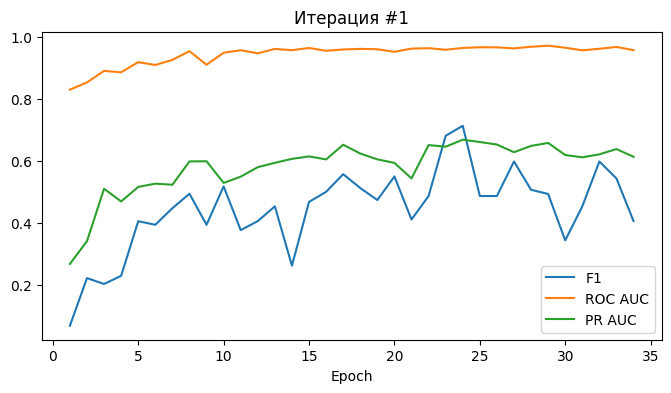

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history_df['epoch'], history_df['f1'], label='F1')
plt.plot(history_df['epoch'], history_df['roc_auc'], label='ROC AUC')
plt.plot(history_df['epoch'], history_df['pr_auc'], label='PR AUC')

plt.title('Итерация #1')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Classification Report:

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00      9947
       fraud       0.91      0.58      0.71        53

    accuracy                           1.00     10000
   macro avg       0.95      0.79      0.86     10000
weighted avg       1.00      1.00      1.00     10000



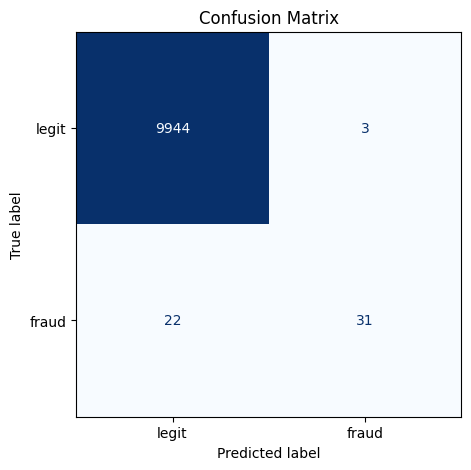

In [16]:
# Сделать предсказания
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_val_arr, dtype=torch.float32).to(device).float())
    probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
    preds  = (probs > 0.5).astype(int)          # обычный порог
    true   = torch.tensor(y_val_arr, dtype=torch.float32).cpu().numpy()

print("Classification Report:\n")
print(classification_report(true, preds, target_names=["legit","fraud"]))

cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["legit","fraud"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()

Теперь найдем лучший порог

In [21]:
# Получаем вероятности и истинные метки, как у вас:
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_val_arr, dtype=torch.float32).to(device).float())
    probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
    true   = torch.tensor(y_val_arr, dtype=torch.float32).cpu().numpy()

# Вычисляем precision, recall и сами пороги
precisions, recalls, thresholds = precision_recall_curve(true, probs)

# thresholds имеет длину len(precisions)-1, т.к. первый precision=1, recall=0 для threshold<min.
# Приводим всё к одному размеру, отбрасывая первый элемент precision/recall
precisions = precisions[1:]
recalls    = recalls[1:]
thresholds = thresholds

# Вычисляем F1 для каждого порога
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

#  Находим порог, при котором F1 максимален
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Лучший порог по F1: {best_threshold:.3f}, F1 = {best_f1:.4f}")

Лучший порог по F1: 0.327, F1 = 0.7368


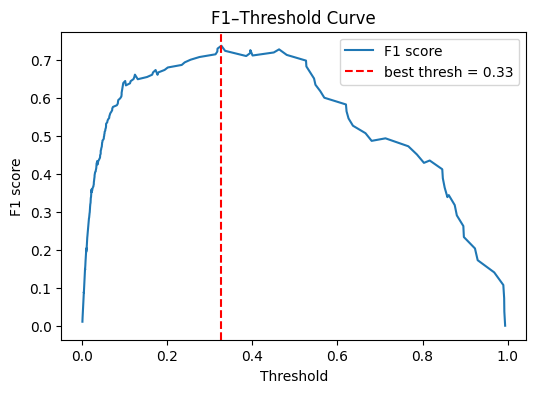

In [19]:
# Визуализация F1 vs порог
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores, label="F1 score")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"best thresh = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1–Threshold Curve")
plt.legend()
plt.show()

Classification Report at best threshold:

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00      9947
       fraud       0.83      0.66      0.74        53

    accuracy                           1.00     10000
   macro avg       0.92      0.83      0.87     10000
weighted avg       1.00      1.00      1.00     10000



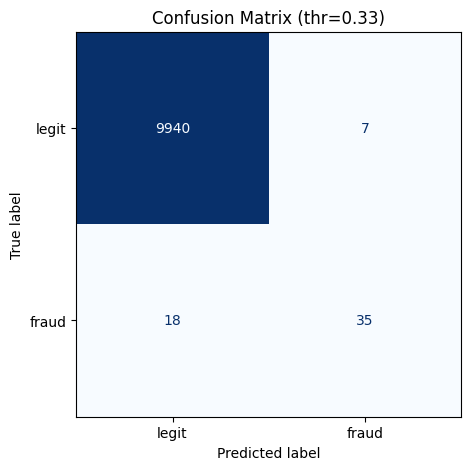

In [20]:
preds_best = (probs > best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Classification Report at best threshold:\n")
print(classification_report(true, preds_best, target_names=["legit","fraud"]))

cm = confusion_matrix(true, preds_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["legit","fraud"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix (thr={best_threshold:.2f})")
plt.show()

Смогли улучшить качество поиска плохих транзакций

Теперь переберем сетку параметров по заданию, найдем лучшую модель

In [18]:
layer_configs = [
    [256,128,64,32],
    [512,256,128],
    [512,256,128,64],
    [1024,512,256]
]
lr_list = [1e-3, 5e-4, 1e-4]
dropout_list = [0.2, 0.3]
best_threshold = 0.327

results_df = grid_search_tabularmlp(
    input_dim=input_dim,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    layer_configs=layer_configs,
    lr_list=lr_list,
    dropout_list=dropout_list,
    threshold=best_threshold,
    num_epochs=50,
    patience=7
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.2168, val_loss=0.0389, f1=0.1724, best_f1=0.0000
Epoch 02: train_loss=0.0315, val_loss=0.0212, f1=0.4225, best_f1=0.1724
Epoch 03: train_loss=0.0236, val_loss=0.0202, f1=0.3768, best_f1=0.4225
Epoch 04: train_loss=0.0220, val_loss=0.0167, f1=0.3768, best_f1=0.4225
Epoch 05: train_loss=0.0203, val_loss=0.0159, f1=0.4615, best_f1=0.4225
Epoch 06: train_loss=0.0197, val_loss=0.0170, f1=0.6019, best_f1=0.4615
Epoch 07: train_loss=0.0186, val_loss=0.0137, f1=0.5316, best_f1=0.6019
Epoch 08: train_loss=0.0176, val_loss=0.0148, f1=0.4118, best_f1=0.6019
Epoch 09: train_loss=0.0181, val_loss=0.0140, f1=0.4872, best_f1=0.6019
Epoch 10: train_loss=0.0173, val_loss=0.0145, f1=0.5263, best_f1=0.6019
Epoch 11: train_loss=0.0166, val_loss=0.0138, f1=0.5476, best_f1=0.6019
Epoch 12: train_loss=0.0167, val_loss=0.0168, f1=0.2903, best_f1=0.6019
Epoch 13: train_loss=0.0157, val_loss=0.0135, f1=0.6173, best_f1=0.6019
Epoch 14: train_loss=0.0159, val_loss=0.0132, f1=0.6353, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.2053, val_loss=0.0356, f1=0.1613, best_f1=0.0000
Epoch 02: train_loss=0.0347, val_loss=0.0196, f1=0.3889, best_f1=0.1613
Epoch 03: train_loss=0.0270, val_loss=0.0208, f1=0.3768, best_f1=0.3889
Epoch 04: train_loss=0.0237, val_loss=0.0180, f1=0.4500, best_f1=0.3889
Epoch 05: train_loss=0.0223, val_loss=0.0169, f1=0.4324, best_f1=0.4500
Epoch 06: train_loss=0.0209, val_loss=0.0172, f1=0.4810, best_f1=0.4500
Epoch 07: train_loss=0.0199, val_loss=0.0175, f1=0.3714, best_f1=0.4810
Epoch 08: train_loss=0.0199, val_loss=0.0163, f1=0.4000, best_f1=0.4810
Epoch 09: train_loss=0.0191, val_loss=0.0166, f1=0.4225, best_f1=0.4810
Epoch 10: train_loss=0.0180, val_loss=0.0163, f1=0.3529, best_f1=0.4810
Epoch 11: train_loss=0.0182, val_loss=0.0155, f1=0.4722, best_f1=0.4810
Epoch 12: train_loss=0.0181, val_loss=0.0154, f1=0.4938, best_f1=0.4810
Epoch 13: train_loss=0.0183, val_loss=0.0155, f1=0.5227, best_f1=0.4938
Epoch 14: train_loss=0.0165, val_loss=0.0157, f1=0.4384, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.3342, val_loss=0.1148, f1=0.1639, best_f1=0.0000
Epoch 02: train_loss=0.0648, val_loss=0.0363, f1=0.3125, best_f1=0.1639
Epoch 03: train_loss=0.0328, val_loss=0.0236, f1=0.3582, best_f1=0.3125
Epoch 04: train_loss=0.0250, val_loss=0.0188, f1=0.3944, best_f1=0.3582
Epoch 05: train_loss=0.0227, val_loss=0.0169, f1=0.3889, best_f1=0.3944
Epoch 06: train_loss=0.0207, val_loss=0.0165, f1=0.4872, best_f1=0.3944
Epoch 07: train_loss=0.0206, val_loss=0.0165, f1=0.4722, best_f1=0.4872
Epoch 08: train_loss=0.0188, val_loss=0.0168, f1=0.4348, best_f1=0.4872
Epoch 09: train_loss=0.0182, val_loss=0.0150, f1=0.4348, best_f1=0.4872
Epoch 10: train_loss=0.0175, val_loss=0.0156, f1=0.3692, best_f1=0.4872
Epoch 11: train_loss=0.0167, val_loss=0.0134, f1=0.6588, best_f1=0.4872
Epoch 12: train_loss=0.0162, val_loss=0.0136, f1=0.6517, best_f1=0.6588
Epoch 13: train_loss=0.0163, val_loss=0.0144, f1=0.6000, best_f1=0.6588
Epoch 14: train_loss=0.0159, val_loss=0.0132, f1=0.7158, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.3303, val_loss=0.1027, f1=0.1724, best_f1=0.0000
Epoch 02: train_loss=0.0706, val_loss=0.0313, f1=0.1724, best_f1=0.1724
Epoch 03: train_loss=0.0358, val_loss=0.0214, f1=0.3582, best_f1=0.1724
Epoch 04: train_loss=0.0287, val_loss=0.0185, f1=0.3333, best_f1=0.3582
Epoch 05: train_loss=0.0255, val_loss=0.0174, f1=0.4225, best_f1=0.3582
Epoch 06: train_loss=0.0222, val_loss=0.0173, f1=0.3333, best_f1=0.4225
Epoch 07: train_loss=0.0215, val_loss=0.0171, f1=0.3824, best_f1=0.4225
Epoch 08: train_loss=0.0205, val_loss=0.0153, f1=0.4872, best_f1=0.4225
Epoch 09: train_loss=0.0208, val_loss=0.0157, f1=0.5128, best_f1=0.4872
Epoch 10: train_loss=0.0194, val_loss=0.0150, f1=0.5301, best_f1=0.5128
Epoch 11: train_loss=0.0194, val_loss=0.0163, f1=0.4675, best_f1=0.5301
Epoch 12: train_loss=0.0185, val_loss=0.0141, f1=0.4872, best_f1=0.5301
Epoch 13: train_loss=0.0183, val_loss=0.0142, f1=0.4865, best_f1=0.5301
Epoch 14: train_loss=0.0181, val_loss=0.0150, f1=0.4658, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.5582, val_loss=0.4584, f1=0.0525, best_f1=0.0000
Epoch 02: train_loss=0.3706, val_loss=0.3137, f1=0.0762, best_f1=0.0525
Epoch 03: train_loss=0.2512, val_loss=0.2047, f1=0.1724, best_f1=0.0762
Epoch 04: train_loss=0.1724, val_loss=0.1431, f1=0.1724, best_f1=0.1724
Epoch 05: train_loss=0.1200, val_loss=0.1027, f1=0.1724, best_f1=0.1724
Epoch 06: train_loss=0.0879, val_loss=0.0719, f1=0.1724, best_f1=0.1724
Epoch 07: train_loss=0.0675, val_loss=0.0535, f1=0.1695, best_f1=0.1724
Epoch 08: train_loss=0.0542, val_loss=0.0420, f1=0.2000, best_f1=0.1724
Epoch 09: train_loss=0.0450, val_loss=0.0357, f1=0.2000, best_f1=0.2000
Epoch 10: train_loss=0.0377, val_loss=0.0286, f1=0.2540, best_f1=0.2000
Epoch 11: train_loss=0.0341, val_loss=0.0264, f1=0.3714, best_f1=0.2540
Epoch 12: train_loss=0.0295, val_loss=0.0237, f1=0.3944, best_f1=0.3714
Epoch 13: train_loss=0.0271, val_loss=0.0215, f1=0.3944, best_f1=0.3944
Epoch 14: train_loss=0.0253, val_loss=0.0197, f1=0.3889, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.8267, val_loss=0.6823, f1=0.0562, best_f1=0.0000
Epoch 02: train_loss=0.5960, val_loss=0.5314, f1=0.0579, best_f1=0.0562
Epoch 03: train_loss=0.4359, val_loss=0.3851, f1=0.0734, best_f1=0.0579
Epoch 04: train_loss=0.3117, val_loss=0.2760, f1=0.0901, best_f1=0.0734
Epoch 05: train_loss=0.2211, val_loss=0.1830, f1=0.0917, best_f1=0.0901
Epoch 06: train_loss=0.1584, val_loss=0.1261, f1=0.1639, best_f1=0.0917
Epoch 07: train_loss=0.1166, val_loss=0.0917, f1=0.1639, best_f1=0.1639
Epoch 08: train_loss=0.0915, val_loss=0.0683, f1=0.1639, best_f1=0.1639
Epoch 09: train_loss=0.0720, val_loss=0.0526, f1=0.1695, best_f1=0.1639
Epoch 10: train_loss=0.0601, val_loss=0.0401, f1=0.1724, best_f1=0.1695
Epoch 11: train_loss=0.0504, val_loss=0.0341, f1=0.1724, best_f1=0.1724
Epoch 12: train_loss=0.0438, val_loss=0.0297, f1=0.1724, best_f1=0.1724
Epoch 13: train_loss=0.0398, val_loss=0.0261, f1=0.2034, best_f1=0.1724
Epoch 14: train_loss=0.0363, val_loss=0.0238, f1=0.2581, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.0920, val_loss=0.0225, f1=0.4691, best_f1=0.0000
Epoch 02: train_loss=0.0239, val_loss=0.0185, f1=0.4225, best_f1=0.4691
Epoch 03: train_loss=0.0208, val_loss=0.0176, f1=0.5870, best_f1=0.4691
Epoch 04: train_loss=0.0183, val_loss=0.0156, f1=0.4058, best_f1=0.5870
Epoch 05: train_loss=0.0169, val_loss=0.0148, f1=0.5823, best_f1=0.5870
Epoch 06: train_loss=0.0177, val_loss=0.0136, f1=0.6364, best_f1=0.5870
Epoch 07: train_loss=0.0166, val_loss=0.0144, f1=0.4935, best_f1=0.6364
Epoch 08: train_loss=0.0166, val_loss=0.0150, f1=0.4865, best_f1=0.6364
Epoch 09: train_loss=0.0163, val_loss=0.0164, f1=0.4872, best_f1=0.6364
Epoch 10: train_loss=0.0150, val_loss=0.0134, f1=0.5195, best_f1=0.6364
Epoch 11: train_loss=0.0158, val_loss=0.0146, f1=0.3939, best_f1=0.6364
Epoch 12: train_loss=0.0157, val_loss=0.0139, f1=0.4507, best_f1=0.6364
Epoch 13: train_loss=0.0162, val_loss=0.0136, f1=0.6889, best_f1=0.6364
Epoch 14: train_loss=0.0147, val_loss=0.0134, f1=0.5000, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.0905, val_loss=0.0238, f1=0.2333, best_f1=0.0000
Epoch 02: train_loss=0.0265, val_loss=0.0190, f1=0.4250, best_f1=0.2333
Epoch 03: train_loss=0.0230, val_loss=0.0196, f1=0.4634, best_f1=0.4250
Epoch 04: train_loss=0.0216, val_loss=0.0170, f1=0.4615, best_f1=0.4634
Epoch 05: train_loss=0.0193, val_loss=0.0154, f1=0.4872, best_f1=0.4634
Epoch 06: train_loss=0.0187, val_loss=0.0158, f1=0.4444, best_f1=0.4872
Epoch 07: train_loss=0.0175, val_loss=0.0154, f1=0.4737, best_f1=0.4872
Epoch 08: train_loss=0.0170, val_loss=0.0141, f1=0.5128, best_f1=0.4872
Epoch 09: train_loss=0.0180, val_loss=0.0154, f1=0.4286, best_f1=0.5128
Epoch 10: train_loss=0.0171, val_loss=0.0157, f1=0.4722, best_f1=0.5128
Epoch 11: train_loss=0.0159, val_loss=0.0140, f1=0.5195, best_f1=0.5128
Epoch 12: train_loss=0.0167, val_loss=0.0152, f1=0.4872, best_f1=0.5195
Epoch 13: train_loss=0.0163, val_loss=0.0151, f1=0.4658, best_f1=0.5195
Epoch 14: train_loss=0.0158, val_loss=0.0149, f1=0.5067, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.1342, val_loss=0.0370, f1=0.3947, best_f1=0.0000
Epoch 02: train_loss=0.0260, val_loss=0.0216, f1=0.1724, best_f1=0.3947
Epoch 03: train_loss=0.0221, val_loss=0.0227, f1=0.2623, best_f1=0.3947
Epoch 04: train_loss=0.0201, val_loss=0.0169, f1=0.5000, best_f1=0.3947
Epoch 05: train_loss=0.0180, val_loss=0.0173, f1=0.4810, best_f1=0.5000
Epoch 06: train_loss=0.0171, val_loss=0.0168, f1=0.5238, best_f1=0.5000
Epoch 07: train_loss=0.0174, val_loss=0.0145, f1=0.5556, best_f1=0.5238
Epoch 08: train_loss=0.0161, val_loss=0.0159, f1=0.4286, best_f1=0.5556
Epoch 09: train_loss=0.0156, val_loss=0.0140, f1=0.6596, best_f1=0.5556
Epoch 10: train_loss=0.0154, val_loss=0.0139, f1=0.6374, best_f1=0.6596
Epoch 11: train_loss=0.0162, val_loss=0.0128, f1=0.6977, best_f1=0.6596
Epoch 12: train_loss=0.0156, val_loss=0.0148, f1=0.4507, best_f1=0.6977
Epoch 13: train_loss=0.0143, val_loss=0.0142, f1=0.4507, best_f1=0.6977
Epoch 14: train_loss=0.0148, val_loss=0.0157, f1=0.2034, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.1587, val_loss=0.0367, f1=0.3714, best_f1=0.0000
Epoch 02: train_loss=0.0301, val_loss=0.0240, f1=0.3944, best_f1=0.3714
Epoch 03: train_loss=0.0245, val_loss=0.0198, f1=0.4615, best_f1=0.3944
Epoch 04: train_loss=0.0207, val_loss=0.0185, f1=0.4058, best_f1=0.4615
Epoch 05: train_loss=0.0213, val_loss=0.0178, f1=0.4471, best_f1=0.4615
Epoch 06: train_loss=0.0199, val_loss=0.0156, f1=0.5185, best_f1=0.4615
Epoch 07: train_loss=0.0188, val_loss=0.0150, f1=0.4675, best_f1=0.5185
Epoch 08: train_loss=0.0175, val_loss=0.0175, f1=0.2034, best_f1=0.5185
Epoch 09: train_loss=0.0185, val_loss=0.0160, f1=0.5250, best_f1=0.5185
Epoch 10: train_loss=0.0170, val_loss=0.0146, f1=0.5814, best_f1=0.5250
Epoch 11: train_loss=0.0166, val_loss=0.0138, f1=0.4722, best_f1=0.5814
Epoch 12: train_loss=0.0174, val_loss=0.0141, f1=0.4865, best_f1=0.5814
Epoch 13: train_loss=0.0159, val_loss=0.0148, f1=0.5926, best_f1=0.5814
Epoch 14: train_loss=0.0162, val_loss=0.0134, f1=0.6190, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.4301, val_loss=0.3583, f1=0.1148, best_f1=0.0000
Epoch 02: train_loss=0.1567, val_loss=0.1563, f1=0.0935, best_f1=0.1148
Epoch 03: train_loss=0.0738, val_loss=0.0809, f1=0.1296, best_f1=0.1148
Epoch 04: train_loss=0.0455, val_loss=0.0451, f1=0.4058, best_f1=0.1296
Epoch 05: train_loss=0.0338, val_loss=0.0391, f1=0.3175, best_f1=0.4058
Epoch 06: train_loss=0.0283, val_loss=0.0291, f1=0.4416, best_f1=0.4058
Epoch 07: train_loss=0.0246, val_loss=0.0268, f1=0.4878, best_f1=0.4416
Epoch 08: train_loss=0.0215, val_loss=0.0236, f1=0.4225, best_f1=0.4878
Epoch 09: train_loss=0.0204, val_loss=0.0210, f1=0.4474, best_f1=0.4878
Epoch 10: train_loss=0.0194, val_loss=0.0200, f1=0.4474, best_f1=0.4878
Epoch 11: train_loss=0.0182, val_loss=0.0183, f1=0.5185, best_f1=0.4878
Epoch 12: train_loss=0.0174, val_loss=0.0179, f1=0.4533, best_f1=0.5185
Epoch 13: train_loss=0.0176, val_loss=0.0171, f1=0.5060, best_f1=0.5185
Epoch 14: train_loss=0.0167, val_loss=0.0164, f1=0.5185, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.3445, val_loss=0.2724, f1=0.0769, best_f1=0.0000
Epoch 02: train_loss=0.1346, val_loss=0.1390, f1=0.1101, best_f1=0.0769
Epoch 03: train_loss=0.0693, val_loss=0.0705, f1=0.1455, best_f1=0.1101
Epoch 04: train_loss=0.0444, val_loss=0.0430, f1=0.3030, best_f1=0.1455
Epoch 05: train_loss=0.0341, val_loss=0.0344, f1=0.3768, best_f1=0.3030
Epoch 06: train_loss=0.0290, val_loss=0.0274, f1=0.3733, best_f1=0.3768
Epoch 07: train_loss=0.0256, val_loss=0.0237, f1=0.3944, best_f1=0.3768
Epoch 08: train_loss=0.0232, val_loss=0.0218, f1=0.4938, best_f1=0.3944
Epoch 09: train_loss=0.0218, val_loss=0.0197, f1=0.4000, best_f1=0.4938
Epoch 10: train_loss=0.0214, val_loss=0.0195, f1=0.4384, best_f1=0.4938
Epoch 11: train_loss=0.0205, val_loss=0.0181, f1=0.5185, best_f1=0.4938
Epoch 12: train_loss=0.0199, val_loss=0.0171, f1=0.5000, best_f1=0.5185
Epoch 13: train_loss=0.0188, val_loss=0.0175, f1=0.5000, best_f1=0.5185
Epoch 14: train_loss=0.0191, val_loss=0.0165, f1=0.5063, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.1123, val_loss=0.0274, f1=0.2034, best_f1=0.0000
Epoch 02: train_loss=0.0246, val_loss=0.0198, f1=0.4000, best_f1=0.2034
Epoch 03: train_loss=0.0213, val_loss=0.0182, f1=0.2333, best_f1=0.4000
Epoch 04: train_loss=0.0192, val_loss=0.0165, f1=0.3824, best_f1=0.4000
Epoch 05: train_loss=0.0187, val_loss=0.0155, f1=0.4932, best_f1=0.4000
Epoch 06: train_loss=0.0177, val_loss=0.0165, f1=0.2623, best_f1=0.4932
Epoch 07: train_loss=0.0184, val_loss=0.0144, f1=0.4800, best_f1=0.4932
Epoch 08: train_loss=0.0164, val_loss=0.0172, f1=0.4267, best_f1=0.4932
Epoch 09: train_loss=0.0172, val_loss=0.0150, f1=0.4722, best_f1=0.4932
Epoch 10: train_loss=0.0168, val_loss=0.0161, f1=0.6408, best_f1=0.4932
Epoch 11: train_loss=0.0161, val_loss=0.0134, f1=0.5679, best_f1=0.6408
Epoch 12: train_loss=0.0166, val_loss=0.0137, f1=0.5432, best_f1=0.6408
Epoch 13: train_loss=0.0157, val_loss=0.0181, f1=0.1724, best_f1=0.6408
Epoch 14: train_loss=0.0154, val_loss=0.0132, f1=0.5385, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.1656, val_loss=0.0259, f1=0.2295, best_f1=0.0000
Epoch 02: train_loss=0.0276, val_loss=0.0205, f1=0.4444, best_f1=0.2295
Epoch 03: train_loss=0.0237, val_loss=0.0180, f1=0.2333, best_f1=0.4444
Epoch 04: train_loss=0.0220, val_loss=0.0197, f1=0.2812, best_f1=0.4444
Epoch 05: train_loss=0.0210, val_loss=0.0169, f1=0.4865, best_f1=0.4444
Epoch 06: train_loss=0.0191, val_loss=0.0171, f1=0.4286, best_f1=0.4865
Epoch 07: train_loss=0.0201, val_loss=0.0150, f1=0.4179, best_f1=0.4865
Epoch 08: train_loss=0.0184, val_loss=0.0148, f1=0.4737, best_f1=0.4865
Epoch 09: train_loss=0.0172, val_loss=0.0144, f1=0.6047, best_f1=0.4865
Epoch 10: train_loss=0.0180, val_loss=0.0134, f1=0.6279, best_f1=0.6047
Epoch 11: train_loss=0.0177, val_loss=0.0188, f1=0.6071, best_f1=0.6279
Epoch 12: train_loss=0.0171, val_loss=0.0145, f1=0.6889, best_f1=0.6279
Epoch 13: train_loss=0.0170, val_loss=0.0147, f1=0.4348, best_f1=0.6889
Epoch 14: train_loss=0.0167, val_loss=0.0137, f1=0.5455, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.2686, val_loss=0.0717, f1=0.1724, best_f1=0.0000
Epoch 02: train_loss=0.0385, val_loss=0.0273, f1=0.1724, best_f1=0.1724
Epoch 03: train_loss=0.0245, val_loss=0.0200, f1=0.4750, best_f1=0.1724
Epoch 04: train_loss=0.0210, val_loss=0.0181, f1=0.4658, best_f1=0.4750
Epoch 05: train_loss=0.0202, val_loss=0.0175, f1=0.2623, best_f1=0.4750
Epoch 06: train_loss=0.0177, val_loss=0.0153, f1=0.3939, best_f1=0.4750
Epoch 07: train_loss=0.0179, val_loss=0.0153, f1=0.4533, best_f1=0.4750
Epoch 08: train_loss=0.0168, val_loss=0.0176, f1=0.4731, best_f1=0.4750
Epoch 09: train_loss=0.0163, val_loss=0.0144, f1=0.5263, best_f1=0.4750
Epoch 10: train_loss=0.0158, val_loss=0.0164, f1=0.3284, best_f1=0.5263
Epoch 11: train_loss=0.0161, val_loss=0.0141, f1=0.6882, best_f1=0.5263
Epoch 12: train_loss=0.0158, val_loss=0.0136, f1=0.7292, best_f1=0.6882
Epoch 13: train_loss=0.0159, val_loss=0.0132, f1=0.5952, best_f1=0.7292
Epoch 14: train_loss=0.0152, val_loss=0.0146, f1=0.7021, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.2731, val_loss=0.0669, f1=0.3143, best_f1=0.0000
Epoch 02: train_loss=0.0436, val_loss=0.0251, f1=0.3582, best_f1=0.3143
Epoch 03: train_loss=0.0285, val_loss=0.0203, f1=0.4000, best_f1=0.3582
Epoch 04: train_loss=0.0242, val_loss=0.0174, f1=0.4444, best_f1=0.4000
Epoch 05: train_loss=0.0219, val_loss=0.0180, f1=0.3175, best_f1=0.4444
Epoch 06: train_loss=0.0211, val_loss=0.0164, f1=0.3889, best_f1=0.4444
Epoch 07: train_loss=0.0197, val_loss=0.0180, f1=0.2623, best_f1=0.4444
Epoch 08: train_loss=0.0187, val_loss=0.0156, f1=0.5393, best_f1=0.4444
Epoch 09: train_loss=0.0190, val_loss=0.0150, f1=0.4416, best_f1=0.5393
Epoch 10: train_loss=0.0184, val_loss=0.0141, f1=0.6154, best_f1=0.5393
Epoch 11: train_loss=0.0177, val_loss=0.0146, f1=0.4722, best_f1=0.6154
Epoch 12: train_loss=0.0165, val_loss=0.0147, f1=0.5316, best_f1=0.6154
Epoch 13: train_loss=0.0166, val_loss=0.0144, f1=0.4118, best_f1=0.6154
Epoch 14: train_loss=0.0175, val_loss=0.0175, f1=0.2623, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.4941, val_loss=0.4071, f1=0.0957, best_f1=0.0000
Epoch 02: train_loss=0.2420, val_loss=0.2132, f1=0.1639, best_f1=0.0957
Epoch 03: train_loss=0.1297, val_loss=0.1159, f1=0.1695, best_f1=0.1639
Epoch 04: train_loss=0.0784, val_loss=0.0751, f1=0.1695, best_f1=0.1695
Epoch 05: train_loss=0.0541, val_loss=0.0524, f1=0.2333, best_f1=0.1695
Epoch 06: train_loss=0.0410, val_loss=0.0406, f1=0.3438, best_f1=0.2333
Epoch 07: train_loss=0.0329, val_loss=0.0313, f1=0.4058, best_f1=0.3438
Epoch 08: train_loss=0.0284, val_loss=0.0263, f1=0.3881, best_f1=0.4058
Epoch 09: train_loss=0.0250, val_loss=0.0244, f1=0.4557, best_f1=0.4058
Epoch 10: train_loss=0.0225, val_loss=0.0207, f1=0.4658, best_f1=0.4557
Epoch 11: train_loss=0.0206, val_loss=0.0196, f1=0.5000, best_f1=0.4658
Epoch 12: train_loss=0.0198, val_loss=0.0187, f1=0.4533, best_f1=0.5000
Epoch 13: train_loss=0.0189, val_loss=0.0176, f1=0.4474, best_f1=0.5000
Epoch 14: train_loss=0.0186, val_loss=0.0167, f1=0.4737, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.5471, val_loss=0.4676, f1=0.0660, best_f1=0.0000
Epoch 02: train_loss=0.3067, val_loss=0.2683, f1=0.0814, best_f1=0.0660
Epoch 03: train_loss=0.1775, val_loss=0.1445, f1=0.0943, best_f1=0.0814
Epoch 04: train_loss=0.1091, val_loss=0.0926, f1=0.1724, best_f1=0.0943
Epoch 05: train_loss=0.0735, val_loss=0.0616, f1=0.0943, best_f1=0.1724
Epoch 06: train_loss=0.0538, val_loss=0.0430, f1=0.1724, best_f1=0.1724
Epoch 07: train_loss=0.0423, val_loss=0.0327, f1=0.2333, best_f1=0.1724
Epoch 08: train_loss=0.0355, val_loss=0.0274, f1=0.2623, best_f1=0.2333
Epoch 09: train_loss=0.0306, val_loss=0.0238, f1=0.4058, best_f1=0.2623
Epoch 10: train_loss=0.0285, val_loss=0.0211, f1=0.3824, best_f1=0.4058
Epoch 11: train_loss=0.0262, val_loss=0.0201, f1=0.3939, best_f1=0.4058
Epoch 12: train_loss=0.0238, val_loss=0.0190, f1=0.5000, best_f1=0.4058
Epoch 13: train_loss=0.0236, val_loss=0.0184, f1=0.4878, best_f1=0.5000
Epoch 14: train_loss=0.0220, val_loss=0.0170, f1=0.4384, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.0649, val_loss=0.0233, f1=0.4267, best_f1=0.0000
Epoch 02: train_loss=0.0243, val_loss=0.0173, f1=0.3881, best_f1=0.4267
Epoch 03: train_loss=0.0199, val_loss=0.0164, f1=0.4444, best_f1=0.4267
Epoch 04: train_loss=0.0184, val_loss=0.0157, f1=0.5238, best_f1=0.4444
Epoch 05: train_loss=0.0199, val_loss=0.0165, f1=0.5517, best_f1=0.5238
Epoch 06: train_loss=0.0171, val_loss=0.0147, f1=0.5783, best_f1=0.5517
Epoch 07: train_loss=0.0183, val_loss=0.0177, f1=0.1724, best_f1=0.5783
Epoch 08: train_loss=0.0163, val_loss=0.0145, f1=0.5316, best_f1=0.5783
Epoch 09: train_loss=0.0173, val_loss=0.0160, f1=0.5000, best_f1=0.5783
Epoch 10: train_loss=0.0165, val_loss=0.0137, f1=0.4935, best_f1=0.5783
Epoch 11: train_loss=0.0155, val_loss=0.0139, f1=0.5063, best_f1=0.5783
Epoch 12: train_loss=0.0154, val_loss=0.0146, f1=0.6190, best_f1=0.5783
Epoch 13: train_loss=0.0163, val_loss=0.0144, f1=0.4533, best_f1=0.6190
Epoch 14: train_loss=0.0153, val_loss=0.0135, f1=0.4507, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.0713, val_loss=0.0259, f1=0.2727, best_f1=0.0000
Epoch 02: train_loss=0.0247, val_loss=0.0184, f1=0.3692, best_f1=0.2727
Epoch 03: train_loss=0.0222, val_loss=0.0195, f1=0.3939, best_f1=0.3692
Epoch 04: train_loss=0.0211, val_loss=0.0175, f1=0.4110, best_f1=0.3939
Epoch 05: train_loss=0.0185, val_loss=0.0150, f1=0.4800, best_f1=0.4110
Epoch 06: train_loss=0.0190, val_loss=0.0168, f1=0.3175, best_f1=0.4800
Epoch 07: train_loss=0.0183, val_loss=0.0173, f1=0.3939, best_f1=0.4800
Epoch 08: train_loss=0.0180, val_loss=0.0162, f1=0.3175, best_f1=0.4800
Epoch 09: train_loss=0.0184, val_loss=0.0148, f1=0.4225, best_f1=0.4800
Epoch 10: train_loss=0.0172, val_loss=0.0151, f1=0.4932, best_f1=0.4800
Epoch 11: train_loss=0.0170, val_loss=0.0143, f1=0.4865, best_f1=0.4932
Epoch 12: train_loss=0.0169, val_loss=0.0154, f1=0.4800, best_f1=0.4932
Epoch 13: train_loss=0.0172, val_loss=0.0179, f1=0.2034, best_f1=0.4932
Epoch 14: train_loss=0.0168, val_loss=0.0155, f1=0.4444, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.0955, val_loss=0.0325, f1=0.3175, best_f1=0.0000
Epoch 02: train_loss=0.0239, val_loss=0.0211, f1=0.4225, best_f1=0.3175
Epoch 03: train_loss=0.0216, val_loss=0.0181, f1=0.2903, best_f1=0.4225
Epoch 04: train_loss=0.0194, val_loss=0.0166, f1=0.5063, best_f1=0.4225
Epoch 05: train_loss=0.0184, val_loss=0.0172, f1=0.5000, best_f1=0.5063
Epoch 06: train_loss=0.0166, val_loss=0.0144, f1=0.4675, best_f1=0.5063
Epoch 07: train_loss=0.0171, val_loss=0.0187, f1=0.3438, best_f1=0.5063
Epoch 08: train_loss=0.0168, val_loss=0.0189, f1=0.2903, best_f1=0.5063
Epoch 09: train_loss=0.0155, val_loss=0.0138, f1=0.6292, best_f1=0.5063
Epoch 10: train_loss=0.0158, val_loss=0.0160, f1=0.5412, best_f1=0.6292
Epoch 11: train_loss=0.0169, val_loss=0.0144, f1=0.6024, best_f1=0.6292
Epoch 12: train_loss=0.0154, val_loss=0.0141, f1=0.5979, best_f1=0.6292
Epoch 13: train_loss=0.0150, val_loss=0.0131, f1=0.7097, best_f1=0.6292
Epoch 14: train_loss=0.0143, val_loss=0.0134, f1=0.7292, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.1221, val_loss=0.0315, f1=0.3824, best_f1=0.0000
Epoch 02: train_loss=0.0276, val_loss=0.0204, f1=0.3438, best_f1=0.3824
Epoch 03: train_loss=0.0236, val_loss=0.0180, f1=0.3714, best_f1=0.3824
Epoch 04: train_loss=0.0218, val_loss=0.0205, f1=0.4941, best_f1=0.3824
Epoch 05: train_loss=0.0192, val_loss=0.0168, f1=0.5647, best_f1=0.4941
Epoch 06: train_loss=0.0200, val_loss=0.0193, f1=0.5000, best_f1=0.5647
Epoch 07: train_loss=0.0180, val_loss=0.0188, f1=0.6667, best_f1=0.5647
Epoch 08: train_loss=0.0182, val_loss=0.0194, f1=0.4225, best_f1=0.6667
Epoch 09: train_loss=0.0176, val_loss=0.0161, f1=0.5185, best_f1=0.6667
Epoch 10: train_loss=0.0174, val_loss=0.0139, f1=0.5067, best_f1=0.6667
Epoch 11: train_loss=0.0164, val_loss=0.0143, f1=0.4737, best_f1=0.6667
Epoch 12: train_loss=0.0160, val_loss=0.0155, f1=0.6000, best_f1=0.6667
Epoch 13: train_loss=0.0159, val_loss=0.0142, f1=0.6374, best_f1=0.6667
Epoch 14: train_loss=0.0159, val_loss=0.0137, f1=0.5750, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.3160, val_loss=0.2111, f1=0.1239, best_f1=0.0000
Epoch 02: train_loss=0.0760, val_loss=0.1054, f1=0.2034, best_f1=0.1239
Epoch 03: train_loss=0.0388, val_loss=0.0556, f1=0.3944, best_f1=0.2034
Epoch 04: train_loss=0.0277, val_loss=0.0411, f1=0.4691, best_f1=0.3944
Epoch 05: train_loss=0.0239, val_loss=0.0313, f1=0.5000, best_f1=0.4691
Epoch 06: train_loss=0.0211, val_loss=0.0247, f1=0.4878, best_f1=0.5000
Epoch 07: train_loss=0.0192, val_loss=0.0215, f1=0.5122, best_f1=0.5000
Epoch 08: train_loss=0.0181, val_loss=0.0214, f1=0.4835, best_f1=0.5122
Epoch 09: train_loss=0.0185, val_loss=0.0191, f1=0.4865, best_f1=0.5122
Epoch 10: train_loss=0.0173, val_loss=0.0189, f1=0.4225, best_f1=0.5122
Epoch 11: train_loss=0.0170, val_loss=0.0177, f1=0.6000, best_f1=0.5122
Epoch 12: train_loss=0.0160, val_loss=0.0178, f1=0.5366, best_f1=0.6000
Epoch 13: train_loss=0.0161, val_loss=0.0162, f1=0.5195, best_f1=0.6000
Epoch 14: train_loss=0.0161, val_loss=0.0166, f1=0.5060, best_f1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.3099, val_loss=0.2069, f1=0.1513, best_f1=0.0000
Epoch 02: train_loss=0.0798, val_loss=0.1176, f1=0.2131, best_f1=0.1513
Epoch 03: train_loss=0.0413, val_loss=0.0778, f1=0.2439, best_f1=0.2131
Epoch 04: train_loss=0.0310, val_loss=0.0368, f1=0.4058, best_f1=0.2439
Epoch 05: train_loss=0.0257, val_loss=0.0280, f1=0.4658, best_f1=0.4058
Epoch 06: train_loss=0.0229, val_loss=0.0243, f1=0.5122, best_f1=0.4658
Epoch 07: train_loss=0.0206, val_loss=0.0218, f1=0.4557, best_f1=0.5122
Epoch 08: train_loss=0.0205, val_loss=0.0300, f1=0.2281, best_f1=0.5122
Epoch 09: train_loss=0.0196, val_loss=0.0189, f1=0.4675, best_f1=0.5122
Epoch 10: train_loss=0.0188, val_loss=0.0188, f1=0.4474, best_f1=0.5122
Epoch 11: train_loss=0.0183, val_loss=0.0169, f1=0.5238, best_f1=0.5122
Epoch 12: train_loss=0.0179, val_loss=0.0175, f1=0.6364, best_f1=0.5238
Epoch 13: train_loss=0.0177, val_loss=0.0159, f1=0.5783, best_f1=0.6364
Epoch 14: train_loss=0.0176, val_loss=0.0167, f1=0.5979, best_f1

,layers,lr,dropout,threshold,f1_at_thr,roc_auc,pr_auc
0,"[512, 256, 128, 64]",0.0001,0.2,0.327,0.732673,0.970018,0.662586
1,"[256, 128, 64, 32]",0.0005,0.2,0.327,0.723404,0.969800,0.682147
2,"[1024, 512, 256]",0.0005,0.2,0.327,0.720000,0.953838,0.675380
3,"[512, 256, 128, 64]",0.0005,0.2,0.327,0.711538,0.958516,0.658797
4,"[512, 256, 128]",0.0005,0.3,0.327,0.708333,0.947691,0.681470
5,"[256, 128, 64, 32]",0.0010,0.2,0.327,0.705882,0.967843,0.671367
6,"[512, 256, 128]",0.0005,0.2,0.327,0.703704,0.970713,0.663370
7,"[1024, 512, 256]",0.0010,0.2,0.327,0.701031,0.962203,0.663992
8,"[512, 256, 128, 64]",0.0010,0.3,0.327,0.701031,0.955544,0.620235
9,"[512, 256, 128]",0.0010,0.2,0.327,0.693069,0.959514,0.671055


In [22]:
# Отсортируем по убыванию f1_at_thr
display(results_df.sort_values('f1_at_thr', ascending=False, ignore_index=True))

,layers,lr,dropout,threshold,f1_at_thr,roc_auc,pr_auc
0,"[512, 256, 128, 64]",0.0001,0.2,0.327,0.732673,0.970018,0.662586
1,"[256, 128, 64, 32]",0.0005,0.2,0.327,0.723404,0.969800,0.682147
2,"[1024, 512, 256]",0.0005,0.2,0.327,0.720000,0.953838,0.675380
3,"[512, 256, 128, 64]",0.0005,0.2,0.327,0.711538,0.958516,0.658797
4,"[512, 256, 128]",0.0005,0.3,0.327,0.708333,0.947691,0.681470
5,"[256, 128, 64, 32]",0.0010,0.2,0.327,0.705882,0.967843,0.671367
6,"[512, 256, 128]",0.0005,0.2,0.327,0.703704,0.970713,0.663370
7,"[1024, 512, 256]",0.0010,0.2,0.327,0.701031,0.962203,0.663992
8,"[512, 256, 128, 64]",0.0010,0.3,0.327,0.701031,0.955544,0.620235
9,"[512, 256, 128]",0.0010,0.2,0.327,0.693069,0.959514,0.671055
